In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np


df = pd.read_csv("amz_uk_price_prediction_dataset.csv")
df.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


### Part 1: Analyzing Best-Seller Trends Across Product Categories

In [7]:
crosstab_result = pd.crosstab(df['category'], df['isBestSeller'])

crosstab_result

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [10]:
pd.DataFrame(crosstab_result).sort_values(by=False, ascending=False)

isBestSeller,False,True
category,,
Sports & Outdoors,835935,330
"Handmade Clothing, Shoes & Accessories",19215,14
Bath & Body,19059,33
Beauty,19010,302
Birthday Gifts,18943,35
...,...,...
Motorbike Chassis,107,0
Plugs,106,1
Alexa Built-In Devices,106,1


In [11]:
crosstab_result_df = pd.DataFrame(crosstab_result)

crosstab_result_df["Proportion"] = crosstab_result_df[True]/(crosstab_result_df[True]+crosstab_result_df[False])

crosstab_result_df.sort_values(by="Proportion", ascending=False)

isBestSeller,False,True,Proportion
category,,,
Grocery,9008,556,0.058135
Smart Home Security & Lighting,98,6,0.057692
Health & Personal Care,9017,552,0.057686
Mobile Phone Accessories,248,11,0.042471
Power & Hand Tools,8353,306,0.035339
...,...,...,...
"CD, Disc & Tape Players",8798,0,0.000000
General Music-Making Accessories,259,0,0.000000
Snowboard Boots,1449,0,0.000000


In [12]:
from scipy.stats import chi2_contingency

chi2_statistic, chi2_p_value, _, expected_freq = chi2_contingency(crosstab_result)

print(f"{chi2_p_value:.2f}")

0.00


In [13]:
from scipy.stats.contingency import association

association(crosstab_result, method="cramer")

0.1222829439760564

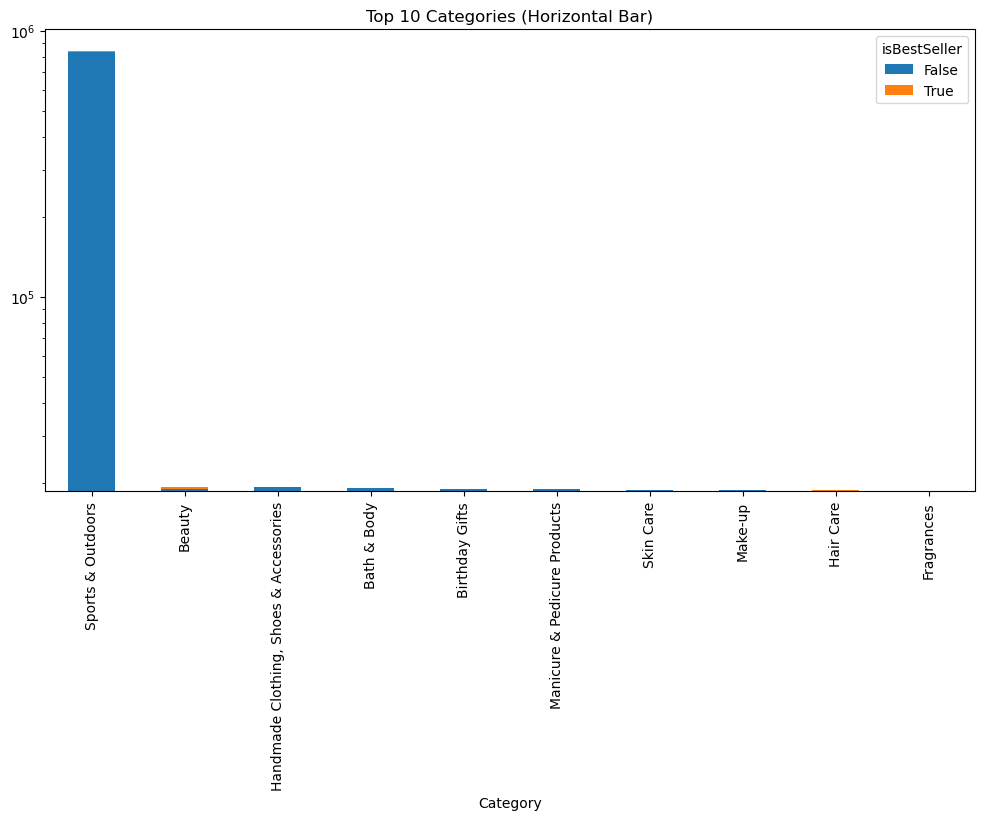

In [15]:
crosstab_result_df_vis = pd.DataFrame(crosstab_result)
crosstab_result_df_vis["Total"] = crosstab_result_df_vis[True] + crosstab_result_df_vis[False]
top10 = crosstab_result_df_vis.nlargest(10, "Total")
top10.drop(columns=["Total"]).plot(kind="bar", stacked=True, figsize=(12,6), log=True)
plt.xlabel("Category")
plt.title("Top 10 Categories (Horizontal Bar)")
plt.show()

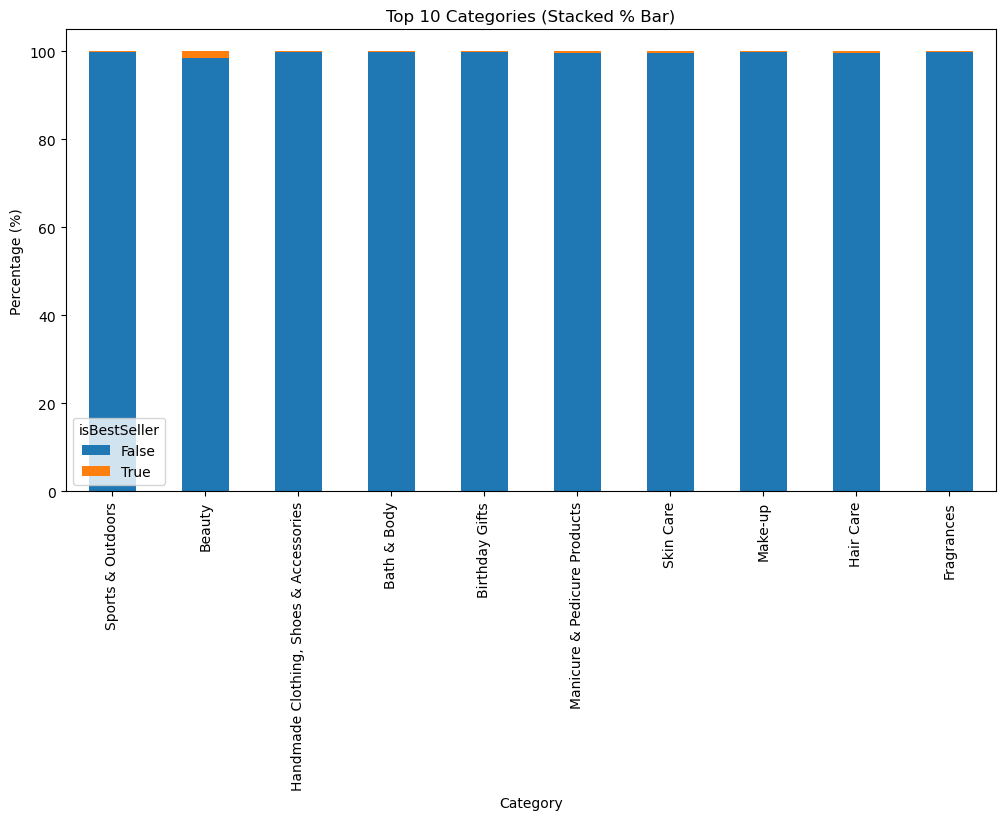

In [16]:
top10_perc = top10.drop(columns=["Total"]).div(top10["Total"], axis=0) * 100

top10_perc.plot(kind="bar", stacked=True, figsize=(12,6))

plt.xlabel("Category")
plt.ylabel("Percentage (%)")
plt.title("Top 10 Categories (Stacked % Bar)")
plt.show()

### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

In [17]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lb = Q1 - 1.5*IQR
ub = Q3 + 1.5*IQR

df_no_out = df[(df['price'] >= lb) & (df['price'] <= ub)]

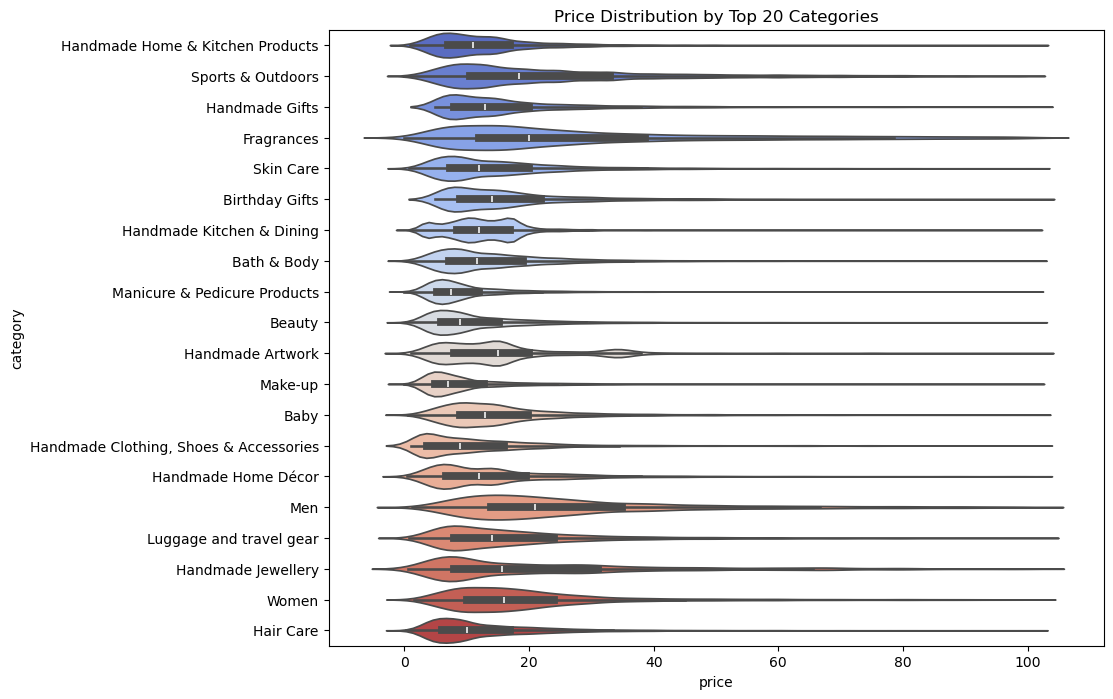

In [18]:
top20_categories = df_no_out['category'].value_counts().nlargest(20).index

df_top20 = df_no_out[df_no_out['category'].isin(top20_categories)]

plt.figure(figsize=(10, 8))
sns.violinplot(data=df_top20, x='price', y='category', palette="coolwarm", hue='category')
plt.title("Price Distribution by Top 20 Categories")
plt.show()

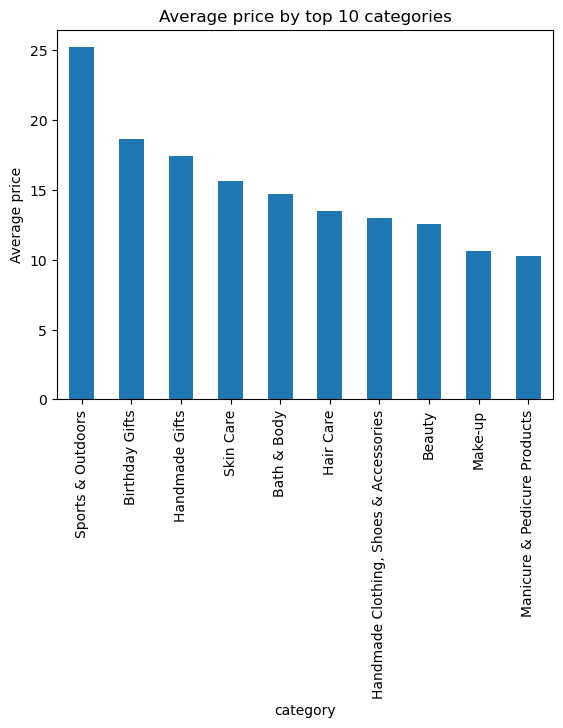

In [19]:
top10 = df_no_out['category'].value_counts().head(10).index
avg_price = (df_no_out[df_no_out['category'].isin(top10)]
             .groupby('category')['price']
             .mean()
             .sort_values(ascending=False))

avg_price.plot(kind='bar')
plt.title("Average price by top 10 categories")
plt.ylabel("Average price")
plt.show()

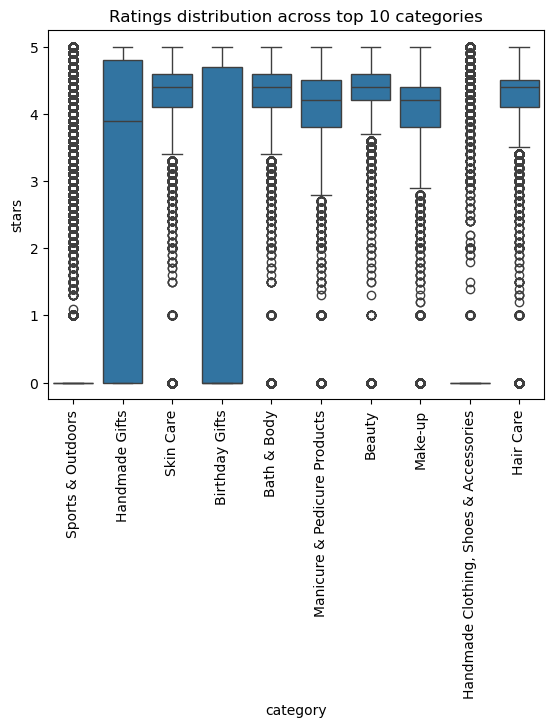

In [20]:
top10 = df_no_out['category'].value_counts().head(10).index
sns.boxplot(data=df_no_out[df_no_out['category'].isin(top10)],
            x='category', y='stars')
plt.xticks(rotation=90)
plt.title("Ratings distribution across top 10 categories")
plt.show()

### Part 3: Investigating the Interplay Between Product Prices and Ratings

In [21]:
corr = df_no_out[['price','stars']].corr()
print(corr)

          price     stars
price  1.000000 -0.077673
stars -0.077673  1.000000


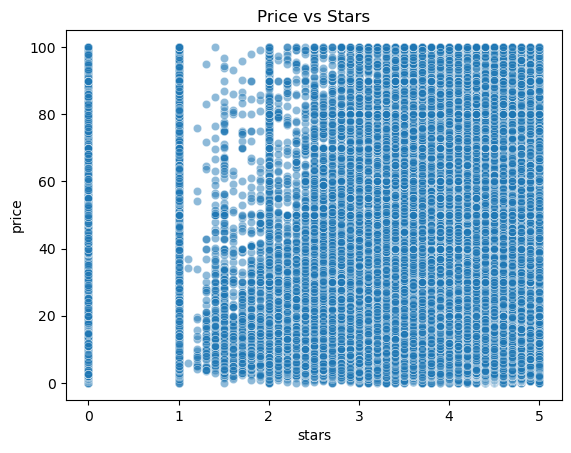

In [22]:
sns.scatterplot(data=df_no_out, x='stars', y='price', alpha=0.5)
plt.title("Price vs Stars")
plt.show()

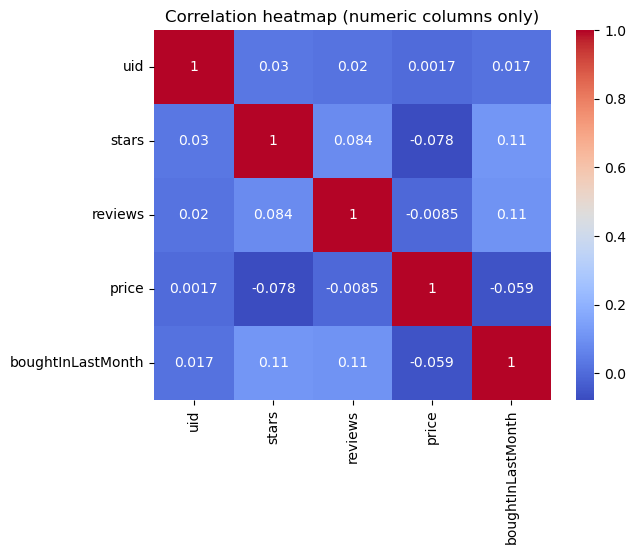

In [23]:
num_df = df_no_out.select_dtypes(include='number')
sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation heatmap (numeric columns only)")
plt.show()

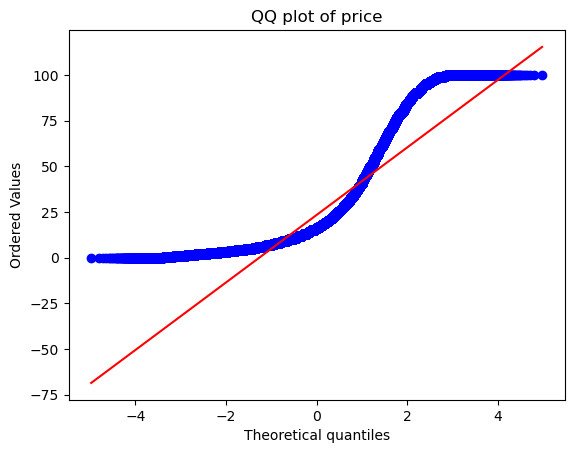

In [24]:
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(df_no_out['price'], dist="norm", plot=plt)
plt.title("QQ plot of price")
plt.show()